In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
!pip uninstall -y tensorflow


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [9]:
!pip install tensorflow==2.12.0


INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 7.5 MB/s eta 0:00:00
  Atte

Epoch 1/40
44/44 [==============================] - 503s 11s/step - loss: 7.3973 - accuracy: 0.2017 - val_loss: 1.7823 - val_accuracy: 0.2237
Epoch 2/40
44/44 [==============================] - 46s 1s/step - loss: 1.4847 - accuracy: 0.4219 - val_loss: 1.4232 - val_accuracy: 0.4518
Epoch 3/40
44/44 [==============================] - 46s 1s/step - loss: 1.0201 - accuracy: 0.6200 - val_loss: 1.3670 - val_accuracy: 0.4956
Epoch 4/40
44/44 [==============================] - 51s 1s/step - loss: 0.7459 - accuracy: 0.7124 - val_loss: 1.4945 - val_accuracy: 0.4605
Epoch 5/40
44/44 [==============================] - 45s 1s/step - loss: 0.5779 - accuracy: 0.8011 - val_loss: 1.4031 - val_accuracy: 0.5000
Epoch 6/40
44/44 [==============================] - 45s 1s/step - loss: 0.3884 - accuracy: 0.8629 - val_loss: 1.7960 - val_accuracy: 0.4649
Epoch 7/40
44/44 [==============================] - 45s 1s/step - loss: 0.2899 - accuracy: 0.9091 - val_loss: 1.5794 - val_accuracy: 0.4956
Epoch 8/40
44/44 [

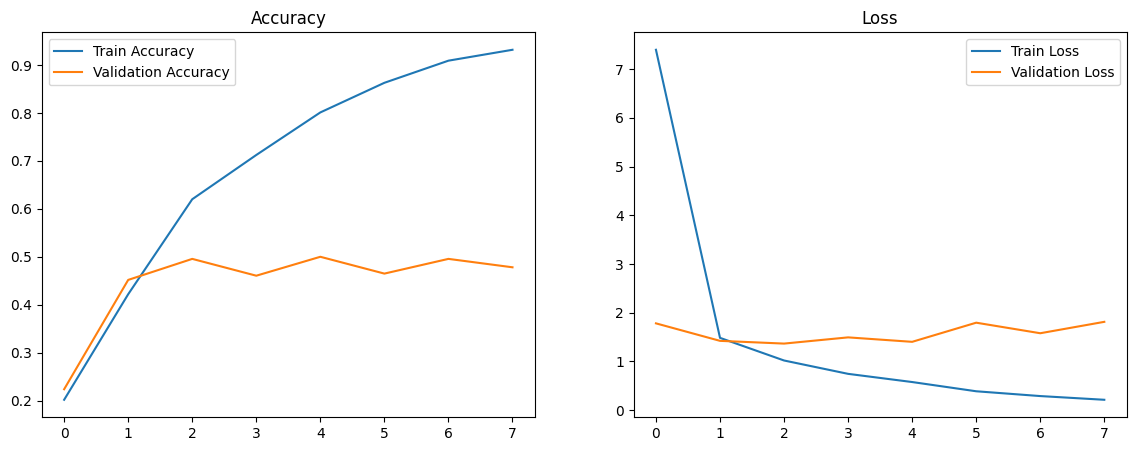

              precision    recall  f1-score   support

       Angry       0.56      0.56      0.56        80
     Disgust       0.55      0.55      0.55        40
        Fear       0.37      0.25      0.30        80
       Happy       0.69      0.55      0.61        80
         Sad       0.55      0.59      0.57        80
    Surprise       0.45      0.55      0.49        40
     Neutral       0.41      0.68      0.51        40

    accuracy                           0.52       440
   macro avg       0.51      0.53      0.51       440
weighted avg       0.52      0.52      0.51       440



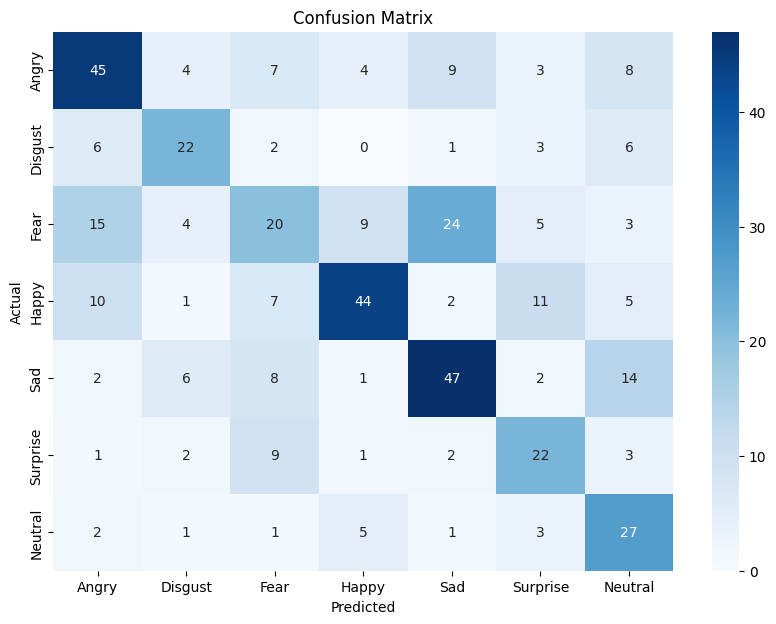

In [10]:
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ===========================
# 1. CẤU HÌNH
# ===========================
SAMPLE_RATE = 22050
DURATION = 3  # seconds
MFCC_FEATURES = 40
FRAME_LENGTH = 129  # số khung MFCC dự kiến
NUM_CLASSES = 7
BATCH_SIZE = 32
EPOCHS = 40  # chạy 40 epoch
LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
LABEL_MAP = {label: i for i, label in enumerate(LABELS)}

# ===========================
# 2. HÀM XỬ LÝ FILE ÂM THANH (MFCC)
# ===========================

def load_mfcc_py(file_path_str):
    file_path_str = file_path_str.decode('utf-8')
    audio, sr = librosa.load(file_path_str, sr=SAMPLE_RATE, duration=DURATION)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=MFCC_FEATURES)
    mfcc = mfcc[:, :FRAME_LENGTH]
    pad_width = FRAME_LENGTH - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    mfcc = mfcc[..., np.newaxis]
    return mfcc.astype(np.float32)

def wrapper_load_mfcc(file_path, label):
    mfcc = tf.numpy_function(load_mfcc_py, [file_path], tf.float32)
    mfcc.set_shape([MFCC_FEATURES, FRAME_LENGTH, 1])
    return mfcc, tf.one_hot(label, depth=NUM_CLASSES)

# ===========================
# 3. TẠO DATASET TỪ THƯ MỤC
# ===========================
def get_dataset(directory):
    filepaths = []
    labels = []
    for label in LABELS:
        path = os.path.join(directory, label)
        if not os.path.exists(path):
            print(f"Warning: folder {path} không tồn tại!")
            continue
        for file in os.listdir(path):
            if file.endswith('.wav'):
                filepaths.append(os.path.join(path, file))
                labels.append(LABEL_MAP[label])
    filepaths = tf.constant(filepaths)
    labels = tf.constant(labels)
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    ds = ds.shuffle(buffer_size=len(filepaths))
    ds = ds.map(wrapper_load_mfcc, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# Thay đổi đường dẫn dataset phù hợp với bạn
train_ds = get_dataset('/content/drive/MyDrive/Colab Notebooks/Dataset/Train-RAVDESS')
val_ds = get_dataset('/content/drive/MyDrive/Colab Notebooks/Dataset/Val-RAVDESS')
test_ds = get_dataset('/content/drive/MyDrive/Colab Notebooks/Dataset/Test-RAVDESS')

# ===========================
# 4. XÂY DỰNG MÔ HÌNH CNN
# ===========================
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(MFCC_FEATURES, FRAME_LENGTH, 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ===========================
# 5. TRAIN MÔ HÌNH VỚI CALLBACKS
# ===========================
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# ===========================
# 5.1. HIỂN THỊ THÔNG TIN MÔ HÌNH
# ===========================
model.summary()

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        weights, biases = layer.get_weights()
        print(f"Layer {layer.name} - Weights shape: {weights.shape}, Biases shape: {biases.shape}")
        break

model.save('final_model_40epochs.keras')

# ===========================
# 6. VẼ BIỂU ĐỒ TRAINING
# ===========================
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

# ===========================
# 7. ĐÁNH GIÁ MÔ HÌNH TRÊN TEST SET
# ===========================
y_true, y_pred = [], []

for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(tf.argmax(y_batch, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=LABELS))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=LABELS, yticklabels=LABELS, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [11]:
model.save('final_model_40epochs.keras')


In [14]:
!ls -lh final_model_40epochs.keras
import os
print(os.getcwd())
from google.colab import files

files.download('final_model_40epochs.keras')


-rw-r--r-- 1 root root 23M May 16 16:24 final_model_40epochs.keras
/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OSError: No file or directory found at /content/drive/MyDrive/Colab Notebooks/best_model.keras